In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import random


In [11]:
def generate_points (num_p, x_range, y_range, z_range=None):
    points = []

    x_val = np.random.uniform(x_range[0], x_range[1], num_p)
    y_val = np.random.uniform(y_range[0], y_range[1], num_p)
    for i in range(num_p):
        x = x_val[i]
        y = y_val[i]
        
        if z_range is not None:
            z = np.random.uniform(z_range[0], z_range[1])
            points.append((x,y,z))
        else:
            points.append((x,y))
    return points
       


In [12]:
num_p= int(input("Enter N dots:"))
x_min = float(input("Enter min x:"))
x_max = float(input("Enter max x:"))
y_min = float(input("Enter min y:"))
y_max = float(input("Enter max y:"))

generate_3d = input("Need to generate 3D (y/n): ").lower()

if generate_3d == 'y':
    z_min = float(input("Enter min z:"))
    z_max = float(input("Enter max z:"))
    points = generate_points(num_p, (x_min, x_max), (y_min, y_max), (z_min, z_max))
else:
    points = generate_points(num_p, (x_min, x_max), (y_min, y_max))



In [13]:
def generate_segments(points):
    segments =[]
    num_points = len(points)
    for i in range(num_points-1):
        for j in range(i+1, num_points):
            segments.append((i,j,np.linalg.norm(np.array(points[i])-np.array(points[j]))))
    return sorted(segments, key=lambda x: x[2])

def calculate_avverage(segments):
    return np.mean([segment[2] for segment in segments])

def sort_segments_by_diff(segments, avverage): #сортує список відрізків за відмінністю їхньої довжини від середньоарифметичної довжини.
    return sorted(segments, key=lambda x: abs(x[2]-avverage))

def is_point_on_segment(p, q, r): #перевіряє, чи точка q лежить на відрузку, визначиному двома точками p r. Функція повертає True,
    # якщо точка знаходиться на відрізку, і False в іншому випадку.
    return (
    (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0])) and
    (q[1] <=max(p[1], r[1]) and q[1] >= min(p[1], r[1]))
    )


Перевірка чи ребра перетинаються

In [14]:
def do_edges_intersect(edge1, edge2, points):
    def orientation(p, q, r): # Ця частина обчислює значення яке є результатом різниці добутків
        # Це використовується для визначення орієнтації трьох точок p, q, і r.
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    p1, q1 = points[edge1[0]], points[edge1[1]]
    p2, q2 = points[edge2[0]], points[edge2[1]]

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and is_point_on_segment(p1, q1, p2):
        return True
    if o2 == 0 and is_point_on_segment(p1, q1, q2):
        return True
    if o3 == 0 and is_point_on_segment(p2, q2, p1):
        return True
    if o4 == 0 and is_point_on_segment(p2, q2, q1):
        return True

    return False


In [15]:
def is_edge_valid(edge, triangles, points):#для перевірки, чи можна вставити відрізок у триангуляцію без порушення умов умова не перетинатись
    #чи відрізок перетинається з будь-яким ребром у кожному з трикутників у списку triangle
    for triangle in triangles:
        for triangle_edge in [(triangle[0], triangle[1]), (triangle[1], triangle[2]), (triangle[2], triangle[0])]:
            if do_edges_intersect(edge, triangle_edge, points):
                return False
    return True

In [16]:
def insert_edge(segment, triangles):#призначена для вставки нового відрізка у триангуляцію.
    new_triangles = []
    for triangle in triangles:
        if is_edge_intersecting_triangle(segment, triangle):
            new_triangles.extend(split_triangle_by_edge(segment, triangle))
        else:
            new_triangles.append(triangle)
    return new_triangles

def split_triangle_by_edge(segment, triangle):# розподіляє трикутник на ребра
    a, b, c = triangle
    return [
        (a, b, segment[1]),
        (b, c, segment[1]),
        (c, a, segment[1])
    ]


def is_edge_intersecting_triangle(segment, triangle):#Функція is_edge_intersecting_triangle призначена для визначення, 
    #чи перетинається відрізок (segment) із трикутником (triangle). Вона викликає функцію do_edges_intersect для кожного з трьох ребер 
    # трикутника і визначає, чи є хоча б один перетин.
    edge1 = (triangle[0], triangle[1])
    edge2 = (triangle[1], triangle[2])
    edge3 = (triangle[2], triangle[0])
    return (
        do_edges_intersect(segment, edge1, points) or
        do_edges_intersect(segment, edge2, points) or
        do_edges_intersect(segment, edge3, points)
    )



In [17]:

def modified_greedy_triangulation(points, segments):# модифікація триангуляції
    # за допомогою вставки відрізків в порядку зменшення різниці їхньої довжини від середньої довжини
    triangles = Delaunay(points).simplices
    average_length = calculate_avverage(segments)
    sorted_segments = sort_segments_by_diff(segments, average_length)

    for segment in sorted_segments:
        if is_edge_valid(segment, triangles, points):
            triangles = insert_edge(segment, triangles)

    return triangles

Generated points:
(6.711457365455032, 1.269157276268936)
(8.51752795145552, 3.3165314465022533)
(3.918082153484266, 1.711593834212509)
(5.27396258810645, 3.2635735721769477)
(7.615371393537047, 1.352573518360624)
(8.837043520457172, 4.398967484355771)
(1.0851162181393588, 0.43366695710831227)
(1.4379002090464759, 2.6689073612610925)
(4.844244829757065, 3.9369044050290873)
(4.1374285894970395, 2.7415288924141676)
(5.630041579084491, 4.454259807287557)
(8.720246297287364, 0.6309672001068833)
(1.1851794270307157, 2.838262638109191)
(5.447385518801951, 2.2140383382647473)
(2.6786821663515896, 3.550031195380007)
(1.976840468735123, 1.0695308381572246)
(6.310655153037639, 0.7127069485386757)
(3.415358955321503, 0.7131931519049701)
(3.8725854479899096, 3.1013324472207056)
(8.686451995402628, 1.3853000217139302)


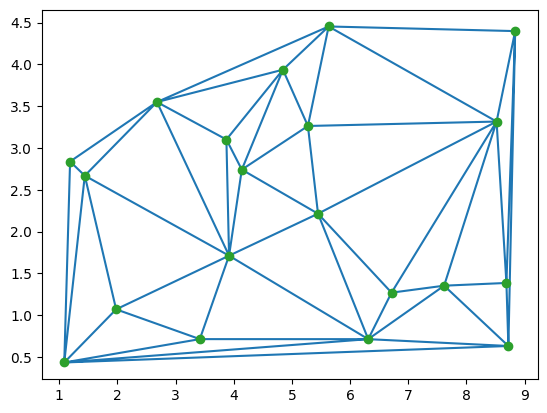

In [18]:
def plot_triangulation(points, triangles):
    plt.triplot(np.array(points)[:, 0], np.array(points)[:, 1], triangles)
    plt.plot(np.array(points)[:, 0], np.array(points)[:, 1], 'o')
    plt.show()


print("Generated points:")
for point in points:
    print(point)

segments = generate_segments(points)
triangles = modified_greedy_triangulation(points, segments)
plot_triangulation(points, triangles)